In [1064]:
import pandas as pd
pd.options.display.precision = 2
import os
import numpy as np 
np.set_printoptions(precision=2)
import re
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE, r2_score as r2
#import scipy.stats as stats
#from datetime import datetime, date
#import statsmodels.api as sm
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import yfinance as yf

## 1. Constructing Hedge Fund Stock Allocation Time Series

In [684]:
hf_data = pd.read_csv('economic data/hedge_fund_data_quarterly.csv') 
hf_data.head()

,Descriptions:,Unit:,Multiplier:,Currency:,Unique Identifier:,Series Name:,1945Q4,1946Q1,1946Q2,1946Q3,...,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,Hedge funds; total financial and nonfinancial ...,Currency,1000000,USD,Z1/Z1/FL622000623.Q,FL622000623.Q,0,ND,ND,ND,...,2612727,2745784,2753534,2664254,2584074,2557691,2624365,2620983,2639975,2758773
1,Hedge funds; real estate; asset,Currency,1000000,USD,Z1/Z1/FL625035003.Q,FL625035003.Q,0,ND,ND,ND,...,127317,142641,153985,164116,148350,149431,161319,173640,170475,147080
2,Hedge funds; total financial assets,Currency,1000000,USD,Z1/Z1/FL624090005.Q,FL624090005.Q,0,ND,ND,ND,...,2485410,2603143,2599549,2500138,2435724,2408260,2463046,2447343,2469500,2611693
3,Hedge funds; foreign currency holdings; asset,Currency,1000000,USD,Z1/Z1/FL623091003.Q,FL623091003.Q,0,ND,ND,ND,...,21290,23440,23657,24282,21836,24177,23722,27032,24767,21607
4,"Hedge funds; checkable, time and savings depos...",Currency,1000000,USD,Z1/Z1/FL623039003.Q,FL623039003.Q,0,ND,ND,ND,...,42017,43396,41902,41414,37665,39910,42231,49926,34726,39728


In [685]:
columns_to_drop = ['Unit:', 'Multiplier:', 'Currency:', 'Unique Identifier:', 'Series Name:']
hf_data.drop(columns = columns_to_drop, inplace= True)
hf_data[hf_data == 0] = np.nan
hf_data[hf_data == 'ND'] = np.nan

In [686]:
hf_data['Descriptions:'].values

array(['Hedge funds; total financial and nonfinancial assets',
       'Hedge funds; real estate; asset',
       'Hedge funds; total financial assets',
       'Hedge funds; foreign currency holdings; asset',
       'Hedge funds; checkable, time and savings deposits; asset',
       'Hedge funds; other cash and cash equivalents; assets',
       'Hedge funds; money market fund shares; assets',
       'Hedge funds; security repurchase agreements; asset',
       'Hedge funds; debt securities; asset (market value)',
       'Hedge funds; Treasury securities; asset (market value)',
       'Hedge funds; agency- and GSE-backed securities; asset (market value)',
       'Hedge funds; municipal securities; asset (market value)',
       'Hedge funds; corporate and foreign bonds; asset (market value)',
       'Hedge funds; total loans; asset',
       'Hedge funds; leveraged loans; asset',
       'Hedge funds; other loans; asset',
       'Hedge funds; corporate equities; asset',
       'Hedge funds; mu

In [687]:
rows_to_keep = [3,4,5,6,8,16,17]
hf_data = hf_data.loc[rows_to_keep]
hf_data['Descriptions:'] = hf_data['Descriptions:'].str.removeprefix('Hedge funds; ').str.removesuffix('; assets').str.removesuffix('; asset').str.removesuffix('; asset (market value)')
hf_data = hf_data.reset_index(drop=True)
hf_data

,Descriptions:,1945Q4,1946Q1,1946Q2,1946Q3,1946Q4,1947Q1,1947Q2,1947Q3,1947Q4,...,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,foreign currency holdings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21290,23440,23657,24282,21836,24177,23722,27032,24767,21607
1,"checkable, time and savings deposits",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42017,43396,41902,41414,37665,39910,42231,49926,34726,39728
2,other cash and cash equivalents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95128,112874,134374,105872,111244,110223,94865,92472,84240,104589
3,money market fund shares,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88460,94558,85290,98084,92448,89577,80194,69334,70174,81198
4,debt securities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,628738,657989,675964,672848,675009,641277,653899,657910,694004,722707
5,corporate equities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1085218,1139779,1071686,954874,904725,936751,952015,976922,948777,999935
6,mutual fund shares,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12054,11784,12230,11802,10824,11267,11432,11125,5975,6800


In [688]:
hf_data_labels = hf_data['Descriptions:']
hf_data = hf_data.iloc[:,1:]

last_nan = []
for i, row in hf_data.iterrows():
    last_nan.append(row.first_valid_index())
print(last_nan)

['2012Q4', '2012Q4', '2012Q4', '2012Q4', '2012Q4', '2012Q4', '2012Q4']


In [689]:
hf_data = hf_data.loc[:,'2012Q4':].set_index(hf_data_labels)
hf_data = hf_data.transpose()
hf_data.index = pd.PeriodIndex(hf_data.index, freq='Q').to_timestamp()
hf_data.head()

Descriptions:,foreign currency holdings,"checkable, time and savings deposits",other cash and cash equivalents,money market fund shares,debt securities,corporate equities,mutual fund shares
2012-10-01,11373,28729,73723,27886,389090,388550,1318
2013-01-01,15823,26778,73256,26678,449813,443669,1043
2013-04-01,16148,31194,74655,24142,459365,459889,1984
2013-07-01,14994,37836,75849,27414,452864,487112,2632
2013-10-01,17689,39878,95725,63921,535920,554277,6035


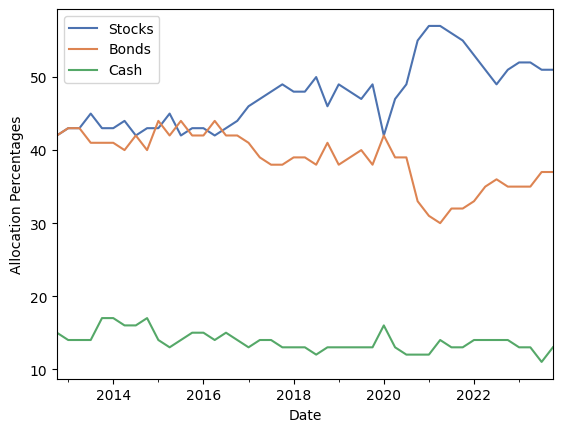

In [1000]:
stocks = hf_data[['corporate equities', 'mutual fund shares']].sum(axis='columns')
bonds = hf_data['debt securities']
cash = hf_data.loc[:,'foreign currency holdings':'money market fund shares'].sum(axis='columns')
total = stocks + bonds + cash
hf_allocations = pd.concat([stocks/total, bonds/total, cash/total], axis = 1) 

labels = ['Stocks', 'Bonds', 'Cash']
hf_allocations = hf_allocations.rename(columns = lambda x: labels[x] if x in hf_allocations.columns else '')
hf_allocations = hf_allocations.round(2) * 100

fig = hf_allocations.plot(kind='line')
fig.set_xlabel('Date')
fig.set_ylabel('Allocation Percentages');

## 2. Constructing the SSI

### 2.1. Importing and processing strategists' stock allocation data.

We begin by importing the strategists' stock allocation recommendation historical data from the [tables](tables/) directory.

In [983]:
tables = []
for year in range(1997,2017):
    df = pd.read_csv(f'tables/strategists\' stock allocation recommendations for {year}.csv')
    df = df[['Date', 'Firm', 'Stock Allocation %']]
    tables.append(df)

df_FA = pd.concat(tables, axis=0, ignore_index=True)
df_FA.dropna(axis=0, inplace=True)
df_FA.index = pd.to_datetime(df_FA['Date'])
df_FA.drop(columns='Date', inplace=True)
df_FA.head()

,Firm,Stock Allocation %
Date,,
1997-01-02,A.G. Edwards,60.0
1997-01-02,Bear Stearns,55.0
1997-01-02,Credit Suisse,60.0
1997-01-02,Dean Witter Reynolds,65.0
1997-01-02,DLJ,45.0


To gain some intuition for the portfolio allocation data we are working with, we compute some summary statistics and look at the distribution of stock allocation recommendations.

There are 7686 total stock allocation portfolio recommendations within the dataset.
The average and median allocation recommendations are 61.39% and 60.0%, respectively.
The maximum and minimum percentages of one's portfolio recommended to allocate to stocks
were 100.0% and 10.0%, respectively.


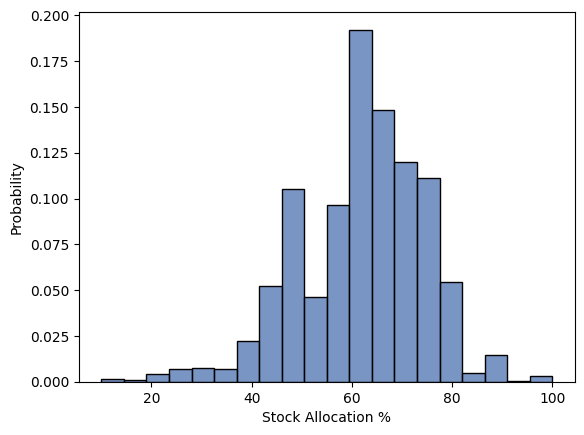

In [1084]:
allocations = df_FA['Stock Allocation %']
count, mean, median, high, low = allocations.size, round(allocations.mean(),2), allocations.median(), allocations.max(), allocations.min()

print(f'There are {count} total stock allocation portfolio recommendations within the dataset.\nThe average and median allocation recommendations are {mean}% and {median}%, respectively.\nThe maximum and minimum percentages of one\'s portfolio recommended to allocate to stocks\nwere {high}% and {low}%, respectively.')

fig = sns.histplot(allocations, bins = 20, stat='probability');

We also want to gain some intuition about how are data is segmented across firms (e.g., US and Canadian (investment) banks). The following code gives the distribution of data points across the firms represented within the dataset.  

The dataset consists of 39 distinct firms.


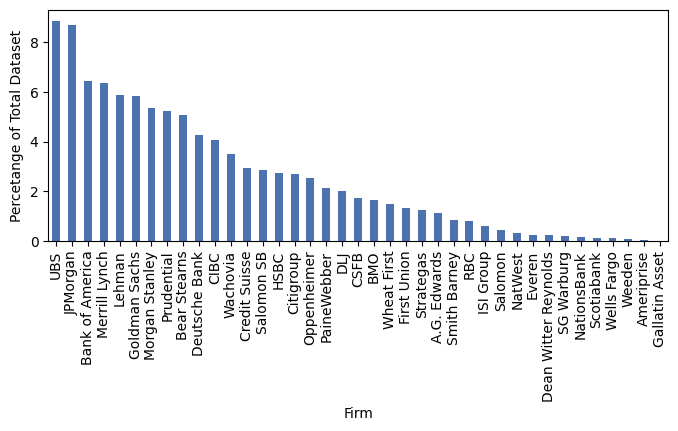

In [977]:
firm_data = allocations['Firm'].value_counts()
print(f'The dataset consists of {firm_data.size} distinct firms.')

df = firm_data / firm_data.sum() * 100
fig = df.plot(kind='bar', figsize= (8,3))
fig.set_ylabel('Percetange of Total Dataset');

One thing we should be mindful of is the potential for missing values within our dataset. The SSI outputs a monthly reading of the average most up-to-date stock allocation recommendation by the various firms’ strategists within the month. Thus, we should determine any months in which we do not have any strategist recommendations.

In [ ]:
dates = pd.PeriodIndex(pd.date_range(start='1997/01/01', end='2016/12/01', freq='MS'), freq='M')
missing_values = dates.difference(allocations.index.to_period(freq='M'))
print(f'Missing values for {missing_values.size} out of {dates.size} total months.')
missing_values

Missing values for 18 out of 240 total months.


PeriodIndex(['1999-12', '2009-04', '2013-12', '2014-12', '2015-03', '2015-05',
             '2015-07', '2015-09', '2015-11', '2015-12', '2016-01', '2016-02',
             '2016-03', '2016-04', '2016-05', '2016-09', '2016-10', '2016-11'],
            dtype='period[M]')

Thankfully, we have relatively few missing values (7.5% of our 20-year observation window). Unfortunately, they are quite concentrated within a narrow period of time around 2015/2016. Since strategists’ allocations seem to not exhibit large sudden deviations (indicated in part by the thin tails in the histogram above) we will take the simplest approach possible and linearly interpolate the missing values.

We can now turn our attention towards computing the SSI time series. This consists of the following steps:
1. For each month within our dataset, we keep only the last allocation recommendation given by each firm within that month.
2. Using these values, we then compute the average stock allocation percentage within each month. The resulting monthly time series is the SSI itself.

In [699]:
allocations = allocations.sort_index(ascending=False)
months = pd.PeriodIndex(allocations.index, freq = 'M')
allocations = allocations.groupby(months, group_keys = False).apply(lambda x: x.drop_duplicates(subset='Firm'))
months = pd.PeriodIndex(allocations.index, freq = 'M')
avg_allocations = allocations.groupby(months, group_keys=False)['Stock Allocation %'].mean()

We plot the resulting indicator time series over the observation window 1997-2016, along with some markers of famous historical market events.

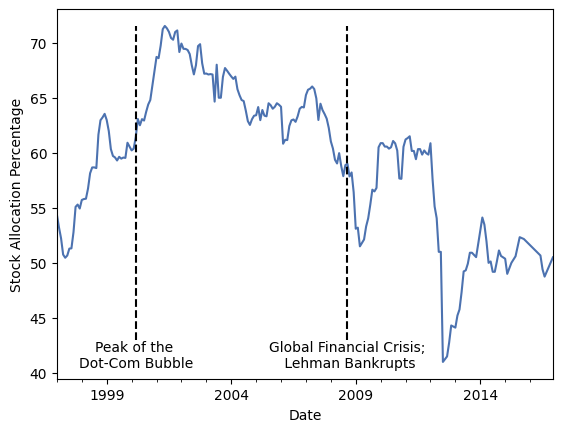

In [896]:
fig = avg_allocations.plot(kind='line')
fig.set_ylabel('Stock Allocation Percentage')
important_dates = [pd.Timestamp(2000,3,10), pd.Timestamp(2008,9,16)]
labels = ['Peak of the \nDot-Com Bubble', 'Global Financial Crisis;\n Lehman Bankrupts']
y_min, y_max = avg_allocations.min() + 2, avg_allocations.max()
fig.vlines(x=important_dates, ymin=y_min, ymax=y_max, colors='black', linestyles='--')
for date, label in zip(important_dates, labels):
    fig.text(date, y_min, label, verticalalignment = 'top', horizontalalignment = 'center')

In [702]:
avg_allocations = avg_allocations.reindex(dates)
interp_allocations = avg_allocations.interpolate(method='linear')

In [703]:
hf_SA = hf_allocations['Stocks']
hf_SA.head()

2012-10-01    42.0
2013-01-01    43.0
2013-04-01    43.0
2013-07-01    45.0
2013-10-01    43.0
Freq: QS-OCT, Name: Stocks, dtype: float64

In [1037]:
hf_SA = hf_allocations['Stocks']
start_date = hf_SA.index[0]
end_date = hf_SA.index[-1]
dates = pd.period_range(start=start_date, end=end_date, freq='M')
hf_SA = hf_SA.reindex(dates)
hf_SA_interp = hf_SA.interpolate(method='linear')
hf_SA_interp.index = pd.PeriodIndex(hf_SA_interp.index, freq='M')
hf_SA_interp.head()

2012-10    42.00
2012-11    42.33
2012-12    42.67
2013-01    43.00
2013-02    43.00
Freq: M, Name: Stocks, dtype: float64

In [713]:
hf_SA = hf_allocations['Stocks']
hf_SA.index = pd.PeriodIndex(hf_SA.index, freq='M')

In [1036]:
hf_allocations.index = pd.PeriodIndex(hf_allocations.index, freq='M')
in_sample_dates = hf_SA.index[hf_SA.index <= interp_allocations.index[-1]]
corr_SSI_HF = round(interp_allocations.corr(hf_SA_interp), 2)

print(f'The hedge fund stock allocation time series has a correlation of {corr_SSI_HF} with the SSI over\nthe shared observation window of {in_sample_dates[0]}--{in_sample_dates[-1]}.')

The hedge fund stock allocation time series has a correlation of 0.1 with the SSI over
the shared observation window of 2012-10--2016-10.


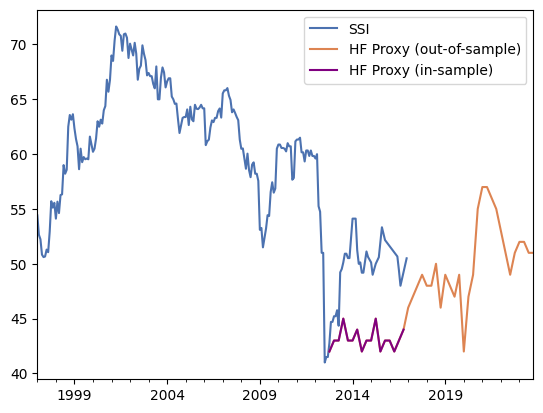

In [998]:
interp_allocations.plot(), hf_SA_interp.plot(), hf_SA_interp.loc[in_sample_dates].plot(color='purple')
labels = ['SSI', 'HF Proxy (out-of-sample)', 'HF Proxy (in-sample)']
plt.legend(labels=labels);

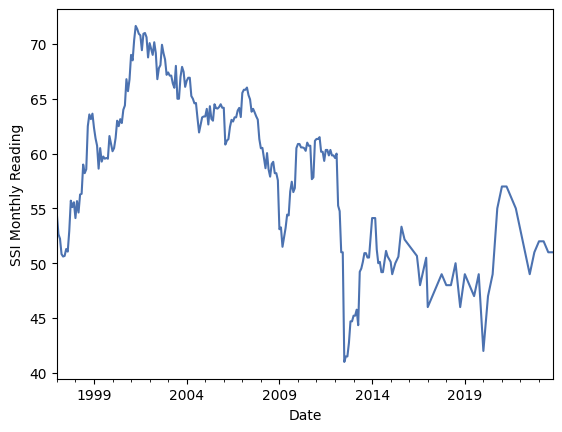

In [1351]:
end_date = interp_allocations.index[-1] + 1
SSI = pd.concat([interp_allocations, hf_SA_interp[end_date:]])

fig = SSI.plot()
fig.set_xlabel('Date')
fig.set_ylabel('SSI Monthly Reading');

## 3. Analyzing the Predictability and Profitability of the SSI

In [1098]:
START_DATE = avg_allocations.index[0]
END_DATE = pd.Period('2024-07', 'M')

In [1100]:
SPX = pd.DataFrame(yf.download('^SPX', start = START_DATE.to_timestamp(), end=END_DATE.to_timestamp(), interval='1mo'))
SPX = SPX['Adj Close']
SPX.head()

[*********************100%%**********************]  1 of 1 completed


Date
1997-01-01    786.16
1997-02-01    790.82
1997-03-01    757.12
1997-04-01    801.34
1997-05-01    848.28
Name: Adj Close, dtype: float64

In [1101]:
SPX_ALR = np.log(SPX / SPX.shift(12))
SPX_ALR = SPX_ALR.dropna()
SPX_ALR.index = pd.PeriodIndex(SPX_ALR.index - pd.Timedelta(365, 'D'), freq='M')
SPX_ALR.name = 'Subsequent 12-month Log Return'
SPX_ALR.head()

Date
1997-01    0.22
1997-02    0.28
1997-03    0.38
1997-04    0.33
1997-05    0.25
Freq: M, Name: Subsequent 12-month Log Return, dtype: float64

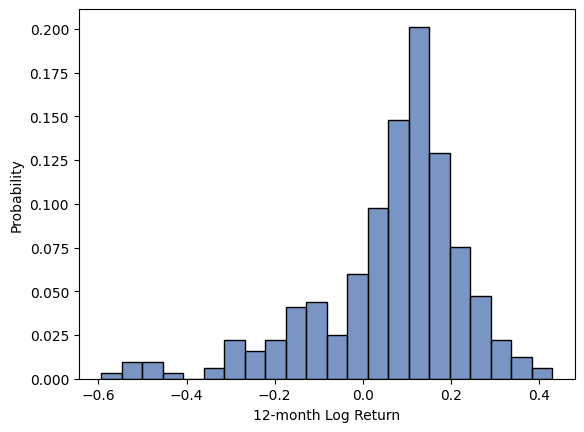

In [1105]:
ax = sns.histplot(SPX_ALR, stat='probability')
num_months = (END_DATE - START_DATE).n + 1
ax.set_xlabel('12-month Log Return');

In [1106]:
series_list = [interp_allocations, hf_SA_interp[pd.Period('2017-01', freq='M'):], SSI]
labels = ['SSI (without hedge fund allocations)', 'hedge fund stock allocation time series', 'SSI (with hedge fund allocations)']
for series, label in zip(series_list, labels):
    print(f'The {label} has a correlation of {round(series.corr(SPX_ALR),2)} with subsequent 12-month S&P500 returns.')

The SSI (without hedge fund allocations) has a correlation of -0.39 with subsequent 12-month S&P500 returns.
The hedge fund stock allocation time series has a correlation of -0.29 with subsequent 12-month S&P500 returns.
The SSI (with hedge fund allocations) has a correlation of -0.39 with subsequent 12-month S&P500 returns.


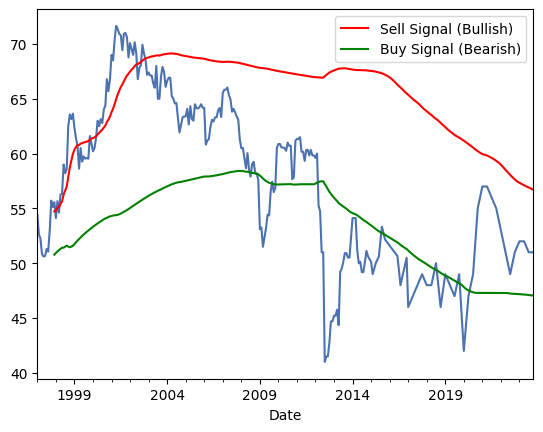

In [1108]:
SSI_mean = SSI.rolling(window = 180, min_periods=12).mean().dropna()
SSI_sd = SSI.rolling(window = 180, min_periods=12).std().dropna()
SSI_bull = SSI_mean + SSI_sd 
SSI_bear = SSI_mean - SSI_sd
fig = SSI.plot()
fig.set_xlabel('Date')
SSI_bull.plot(color='red', label='Sell Signal (Bullish)'), SSI_bear.plot(color='green', label='Buy Signal (Bearish)')
fig.legend();

In [1133]:
buy_signal = SSI[SSI - SSI_bear < 0].dropna().index
buy_signal = buy_signal[buy_signal < END_DATE]
sell_signal = SSI[SSI - SSI_bull > 0].dropna().index
sell_signal = sell_signal[sell_signal < END_DATE]

BS_returns = SPX_ALR[buy_signal]
SS_returns = SPX_ALR[sell_signal]

In [ ]:
sns.barplot()

In [1166]:
buy_signal, sell_signal

(PeriodIndex(['2008-07', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04',
              '2009-05', '2009-06', '2009-07', '2009-08',
              ...
              '2019-05', '2019-06', '2019-07', '2019-08', '2019-11', '2019-12',
              '2020-01', '2020-02', '2020-03', '2020-04'],
             dtype='period[M]', length=104),
 PeriodIndex(['1997-12', '1998-02', '1998-04', '1998-05', '1998-06', '1998-07',
              '1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01',
              '1999-02', '1999-11', '2000-04', '2000-05', '2000-06', '2000-07',
              '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01',
              '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07',
              '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01',
              '2002-02', '2002-03', '2002-04', '2002-05', '2002-09', '2002-10'],
             dtype='period[M]'))

In [1219]:
df['Date']

0      1997-12
1      1998-01
2      1998-02
3      1998-03
4      1998-04
        ...   
303    2023-03
304    2023-04
305    2023-05
306    2023-06
307     Signal
Name: Date, Length: 308, dtype: object

In [1222]:
signals = pd.Series(0, index = SPX_ALR_sample.index)
signals.tail()

Date
2023-03    0
2023-04    0
2023-05    0
2023-06    0
Signal     0
dtype: int64

In [1232]:
signals = pd.Series('No Signal', index = SPX_ALR_sample.index)
signals[buy_signal] = 'Buy'
signals[sell_signal] = 'Sell'
signals.name='Signal'
df = pd.concat([SPX_ALR_sample, signals], axis=1)
df = df.reset_index()
df.head()

,Date,Subsequent 12-Month Return,Signal
0,1997-12,0.24,Sell
1,1998-01,0.27,No Signal
2,1998-02,0.17,Sell
3,1998-03,0.15,No Signal
4,1998-04,0.18,Sell


In [1168]:
SPX_ALR_sample[SPX_ALR_sample<0].size, SS_returns.size

(80, 42)

In [1169]:
SPX_ALR_sample[SPX_ALR_sample>0].size, BS_returns.size

(227, 104)

In [ ]:
SPX_ALR_sample = SPX_ALR.loc[pd.Period('1997/12', freq='M'):] 
count = SPX_ALR_sample.size
SPX_pos_returns = SPX_ALR_sample[SPX_ALR_sample>0]
SPX_neg_returns = SPX_ALR_sample[SPX_ALR_sample<0]
sign = ['positive', 'negative']
trade = ['buy', 'sell']
start_date, end_date = SSI_mean.index[0], SSI_mean.index[-1]

In [1355]:
buy_accuracy_benchmark = SPX_pos_returns.size / count
sell_accuracy_benchmark = SPX_neg_returns.size / count
BS_accuracy = BS_returns[BS_returns>0].size / BS_returns.size
SS_accuracy = SS_returns[SS_returns<0].size / SS_returns.size

signed_returns = np.round(np.array([[buy_accuracy_benchmark, BS_accuracy], [sell_accuracy_benchmark, SS_accuracy]]),2) * 100

print(f'Backtest Period: {START_DATE}--{END_DATE - 12}.')
for i, row in enumerate(signed_returns):
    print(f'{i+1}. Percentage of months in which subsequent 12-month return of S&P 500 is {sign[i]}: {row[0]}%.')
    print(f'Percentage of months sell side indicator gave {trade[i]} signal in which subsequent 12-month return of S&P 500 is {sign[i]}: {row[1]}%.')

Backtest Period: 1997-01--2023-07.
1. Percentage of months in which subsequent 12-month return of S&P 500 is positive: 74.0%.
Percentage of months sell side indicator gave buy signal in which subsequent 12-month return of S&P 500 is positive: 88.0%.
2. Percentage of months in which subsequent 12-month return of S&P 500 is negative: 26.0%.
Percentage of months sell side indicator gave sell signal in which subsequent 12-month return of S&P 500 is negative: 64.0%.


1. The SSI buy signal identified 40.09% of all months between 1997-01 and 2023-07
in which the subsequent 12-month return of the S&P was positive.
2. The SSI sell signal identified 33.75% of all months between 1997-01 and 2023-07
in which the subsequent 12-month return of the S&P was negative.


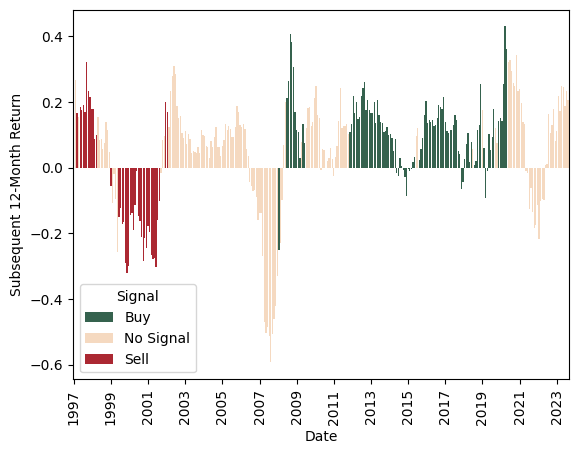

In [1338]:
signals = pd.Series('No Signal', index = SPX_ALR_sample.index)
signals[buy_signal] = 'Buy'
signals[sell_signal] = 'Sell'
signals.name='Signal'
df = pd.concat([SPX_ALR_sample, signals], axis=1)
df = df.reset_index()

# Plot 12-month return time series of S&P overlayed with SSI trade signals.
fig = sns.barplot(data = df, x='Date', y='Subsequent 12-Month Return', hue='Signal', hue_order=['Buy', 'No Signal', 'Sell'], palette=["#2D6A4F", "#fed9b7", "#C1121F"])
fig.set_xticks(range(0,310,23))
fig.set_xticklabels(pd.period_range(start='1997-12', end='2023-07', freq='2Y'));
fig.tick_params(axis='x', rotation=90)

#Compute percentage of S&P positive and negative 12-month returns SSI trade signals were able to predict.

BS_strength = BS_returns[BS_returns>0].size / SPX_pos_returns.size * 100
SS_strength = SS_returns[SS_returns<0].size / SPX_neg_returns.size * 100

strengths = np.round([BS_strength, SS_strength],2)

for i, percentage in enumerate(strengths):
    print(f'{i+1}. The SSI {trade[i]} signal identified {percentage}% of all months between {START_DATE} and {END_DATE - 12}\nin which the subsequent 12-month return of the S&P was {sign[i]}.');

In [821]:
returns = []
for buy_date in buy_signal:
    buy_date = buy_date.to_timestamp()
    for sell_date in sell_signal:
        sell_date = sell_date.to_timestamp()
        returns.append(np.log(SPX[sell_date]/SPX[buy_date]))

In [823]:
returns = np.array(returns)
returns

array([-0.27, -0.19, -0.13, ..., -1.  , -1.27, -1.19])

In [825]:
BS_returns.head()

2008-07   -0.25
2008-12    0.21
2009-01    0.26
2009-02    0.41
2009-03    0.38
Freq: M, Name: Subsequent 12-Month Return, dtype: float64

Text(0.5, 0, 'Subsequent 12-month return')

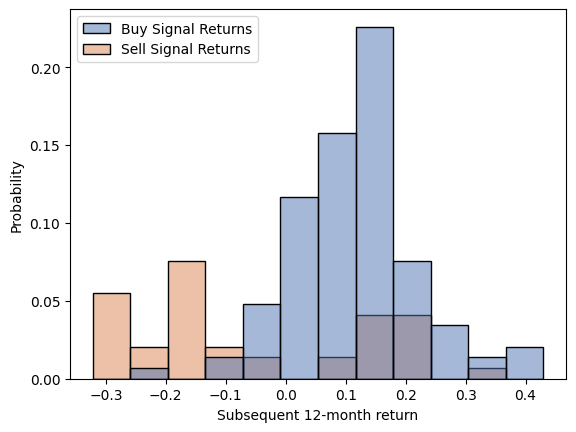

In [1089]:
df = pd.concat([BS_returns, SS_returns], axis = 1)
df.columns = ['Buy Signal Returns', 'Sell Signal Returns']
fig = sns.histplot(df, stat='probability') 
fig.set_xlabel('Subsequent 12-month return')

In [902]:
BS_returns.sum(), SS_returns.sum()

(12.301564669101335, -2.39973850480043)

In [437]:
hf_SA_interp.corr(SPX_ALR)

-0.1770595923450094

In [952]:
HFA.corr(SPX_AR[pd.Timestamp(2012,10,1):])

-0.2644856763367782

In [953]:
SI.corr(SPX_AR[SI.index])

-0.42345946843305565

In [1134]:
SSI.name = 'Sell Side Indicator'
SPX_ALR.name = 'Subsequent 12-Month Return'
end_date = pd.Period('2023/06', freq='M')
df = pd.concat([SSI[:end_date], SPX_ALR.loc[SSI[:end_date].index]], axis=1)
df.head()

,Sell Side Indicator,Subsequent 12-Month Return
1997-01,54.41,0.22
1997-02,52.65,0.28
1997-03,52.24,0.38
1997-04,50.83,0.33
1997-05,50.61,0.25


Mean-squared error is: 0.024
R^2 Score: 0.151


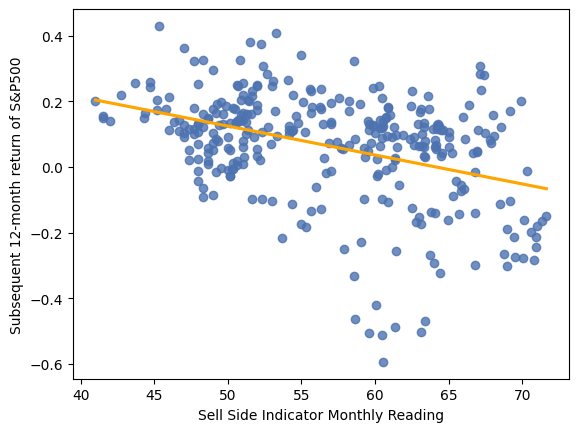

In [604]:
X = df[['Sell Side Indicator']]
y = df['Subsequent 12-Month Return']

model = LR()
model.fit(X, y)
y_pred = model.predict(X)

print(f'Mean-squared error is: {np.round(MSE(y, y_pred),3)}')
print(f'R^2 Score: {np.round(r2(y, y_pred),3)}')

sns.regplot(df, x='Sell Side Indicator', y='Subsequent 12-Month Return', ci = None, line_kws={'color' : 'orange'})
plt.xlabel('Sell Side Indicator Monthly Reading')
plt.ylabel('Subsequent 12-month return of S&P500')
plt.show()